<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started with Instance Segmentation using IceVision

## Introduction

This tutorial walk you through the different steps of training the fridge dataset. the IceVision Framework is an **agnostic framework**. As an illustration, we will train our model using both the [fastai](https://github.com/fastai/fastai) library, and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) libraries.

For more information about how the fridge dataset as well as its corresponding parser check out the [pennfudan folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/pennfudan) in icedata.

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [2]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!chmod +x install_colab.sh && ./install_colab.sh

## Imports

In [3]:
from icevision.all import *

## Model
To create a model, we need to:

* Choose one of the **models** supported by IceVision
* Choose one of the **backbones** corresponding to a chosen model
* Determine the **number of the object classes**: This will be done after parsing a dataset. Check out the Parsing Section 

## Choose a model and backbone

**TorchVision**

In [4]:
model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet34_fpn()

## Datasets : Pennfudan
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [6]:
# Loading Data
data_dir = icedata.pennfudan.load_data()

In [1]:
train_ds, valid_ds = icedata.pennfudan.dataset(data_dir)

### Displaying the same image with different transforms

Note:
> Transforms are applied **lazily**, meaning they are only applied when we grab (get) an item.
> This means that, if you have augmentation (random) transforms, each time you get the **same** item from 
> the dataset you will get a slightly different version of it.

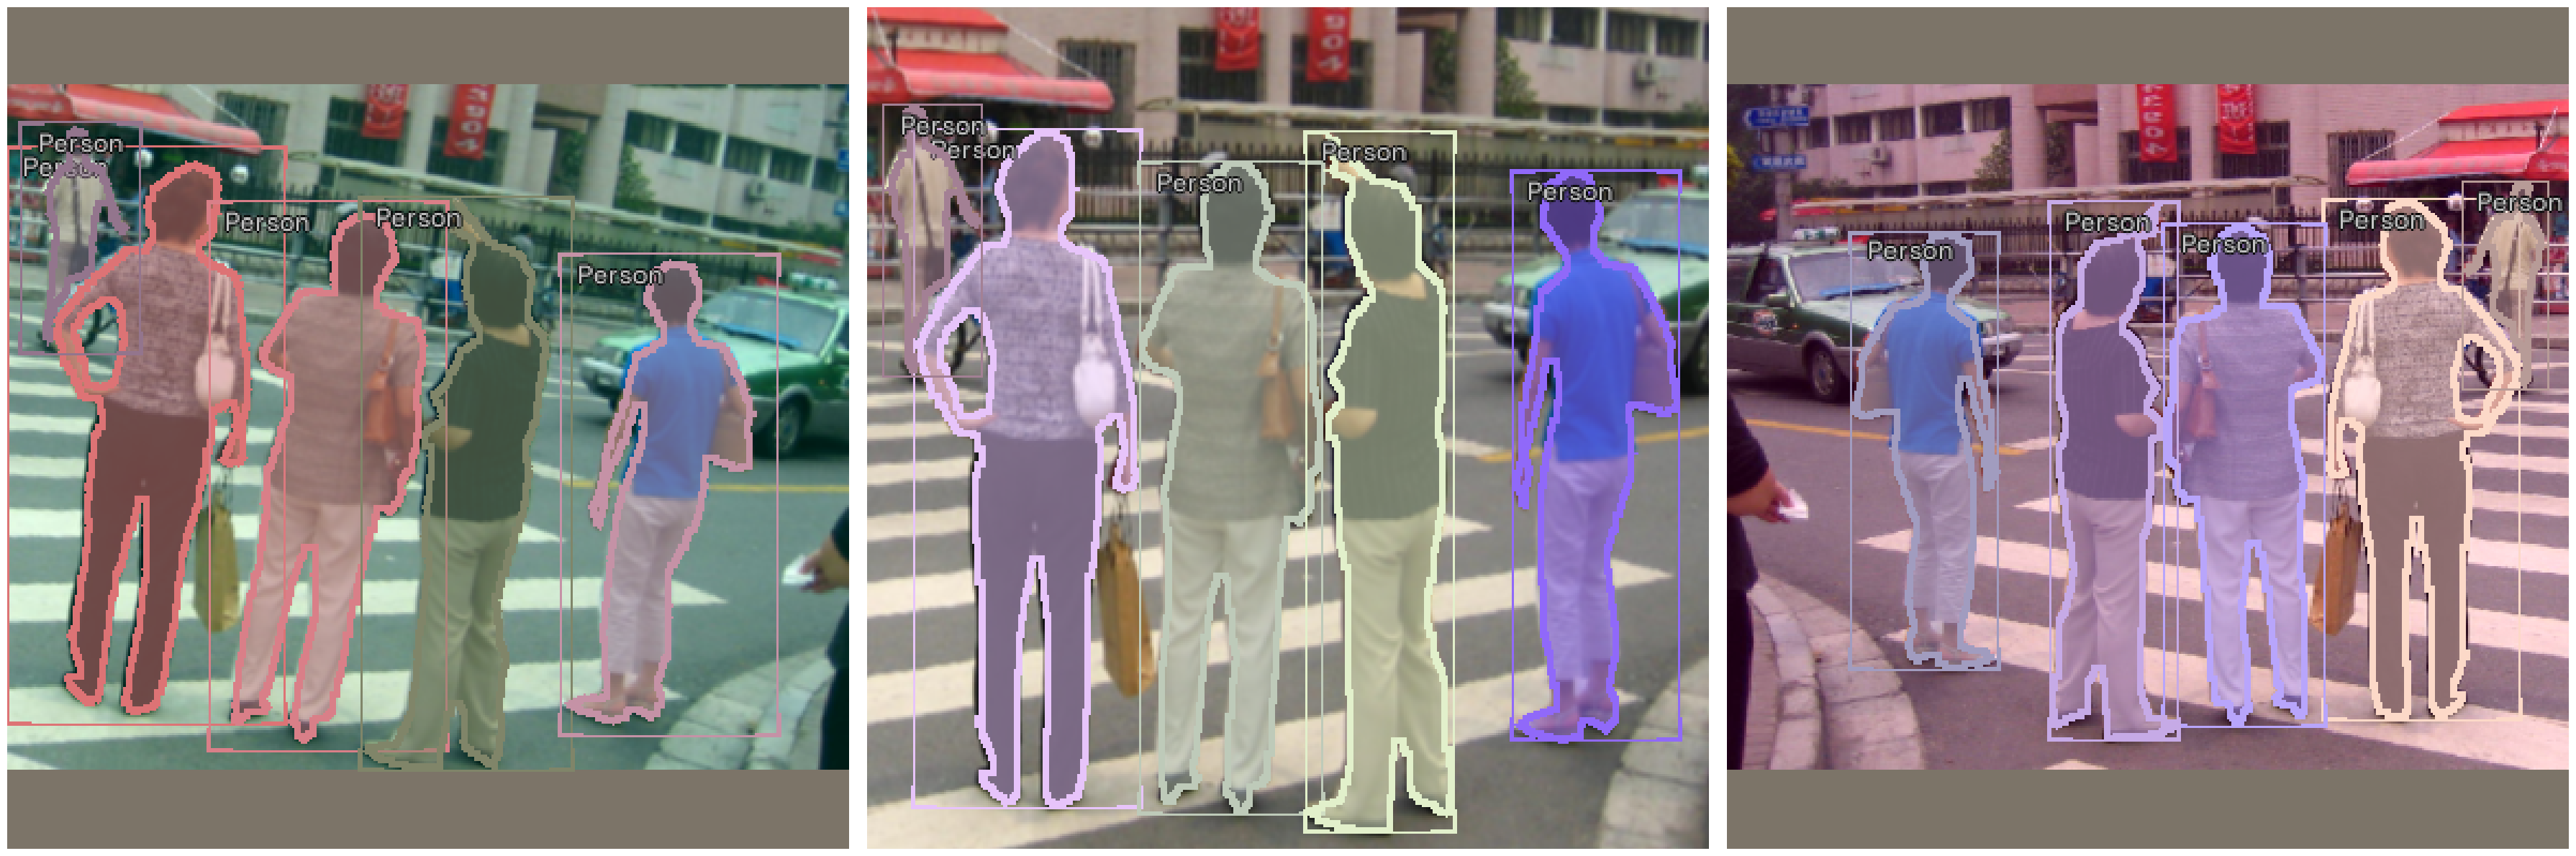

In [8]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

## DataLoader

In [9]:
# DataLoaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

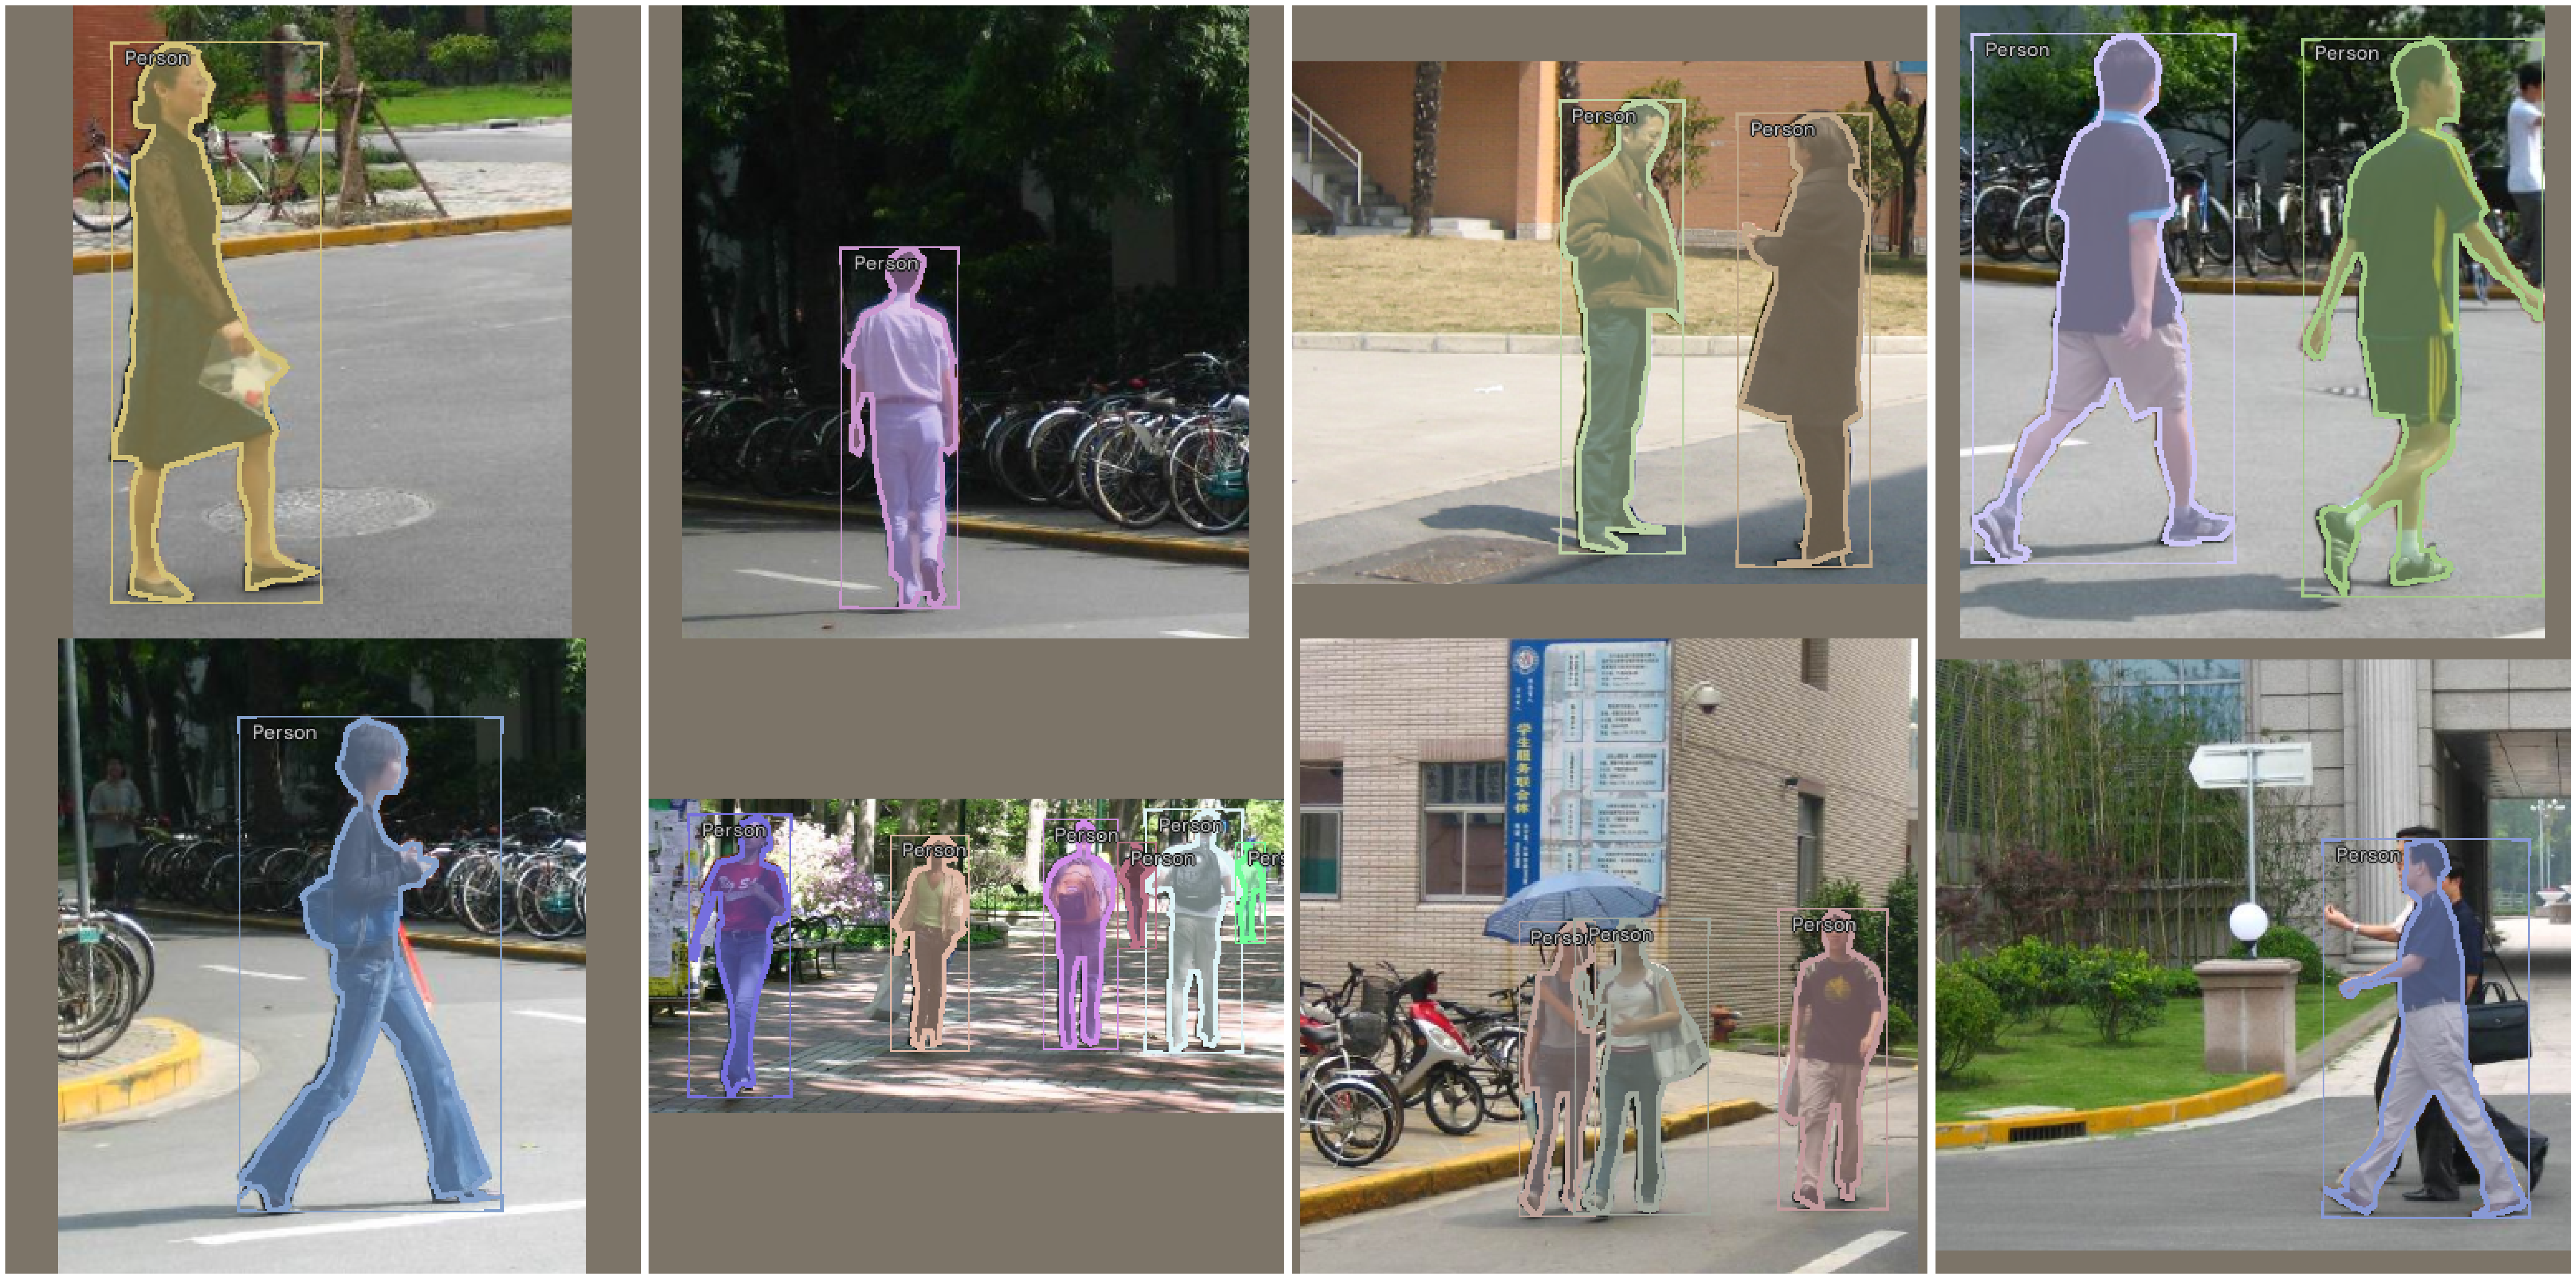

In [10]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Model

Now that we determined the number of classes (`num_classes`), we can create our `model` object.

In [13]:
# TODO: Better flow for train_ds
model = model_type.model(backbone=backbone, num_classes=icedata.pennfudan.NUM_CLASSES) 

## Metrics

In [14]:
metrics = [COCOMetric(metric_type=COCOMetricType.mask)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [15]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=1.737800812406931e-05)

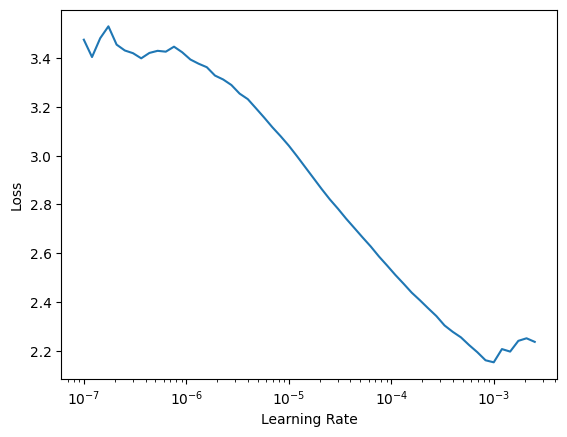

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(20, 1e-4, freeze_epochs=1)

### Training using Lightning

In [ ]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=20, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Show Results

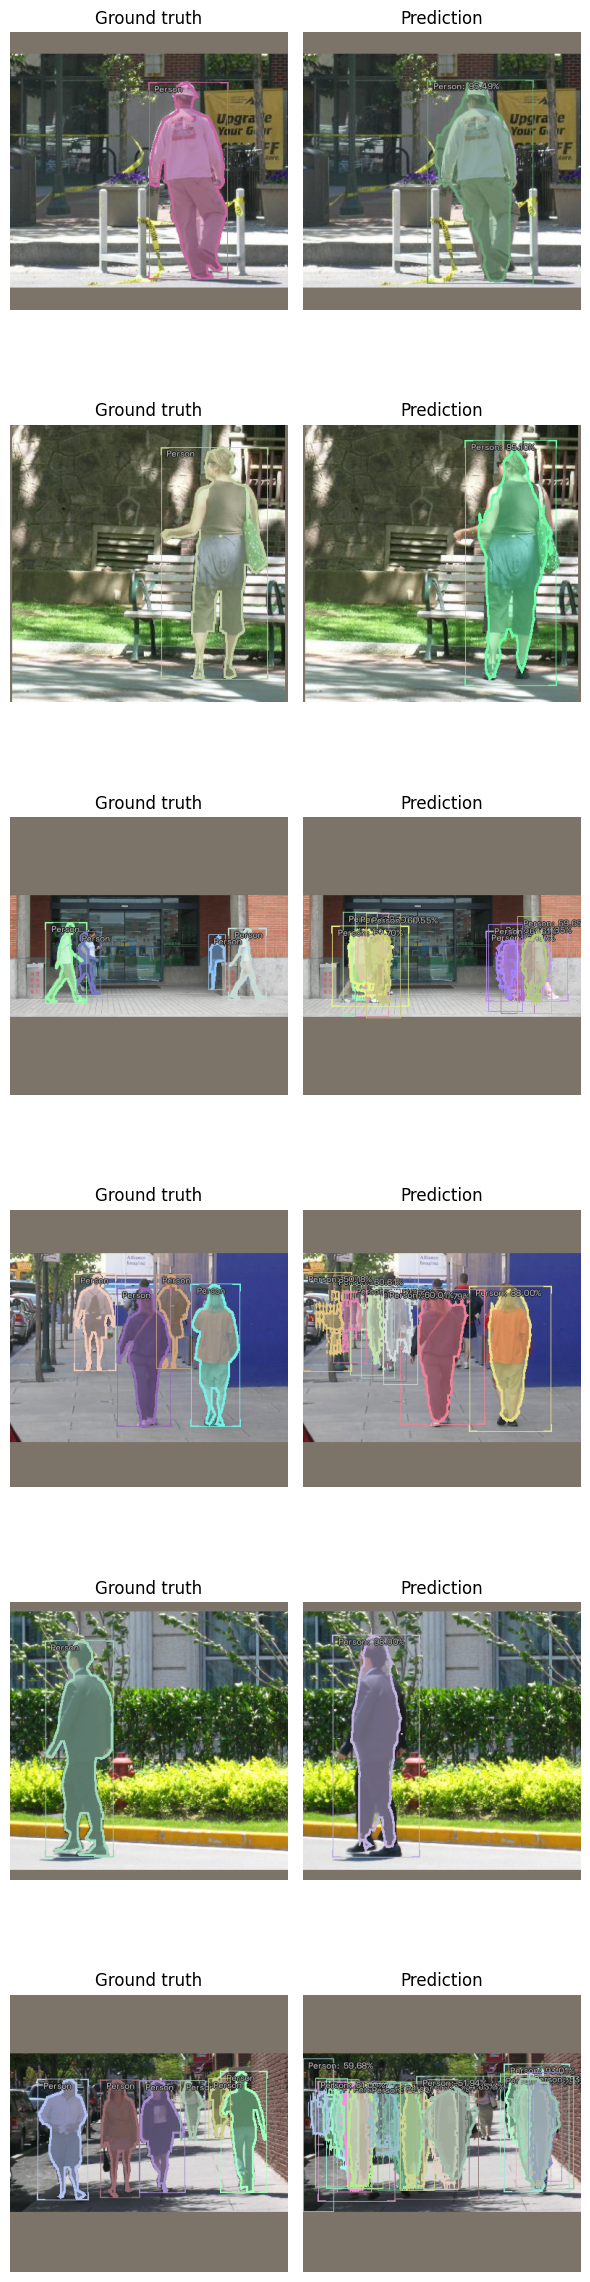

In [18]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batches at the time: This option is more memory efficient. 


> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [19]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_dl(model, infer_dl, keep_images=True)

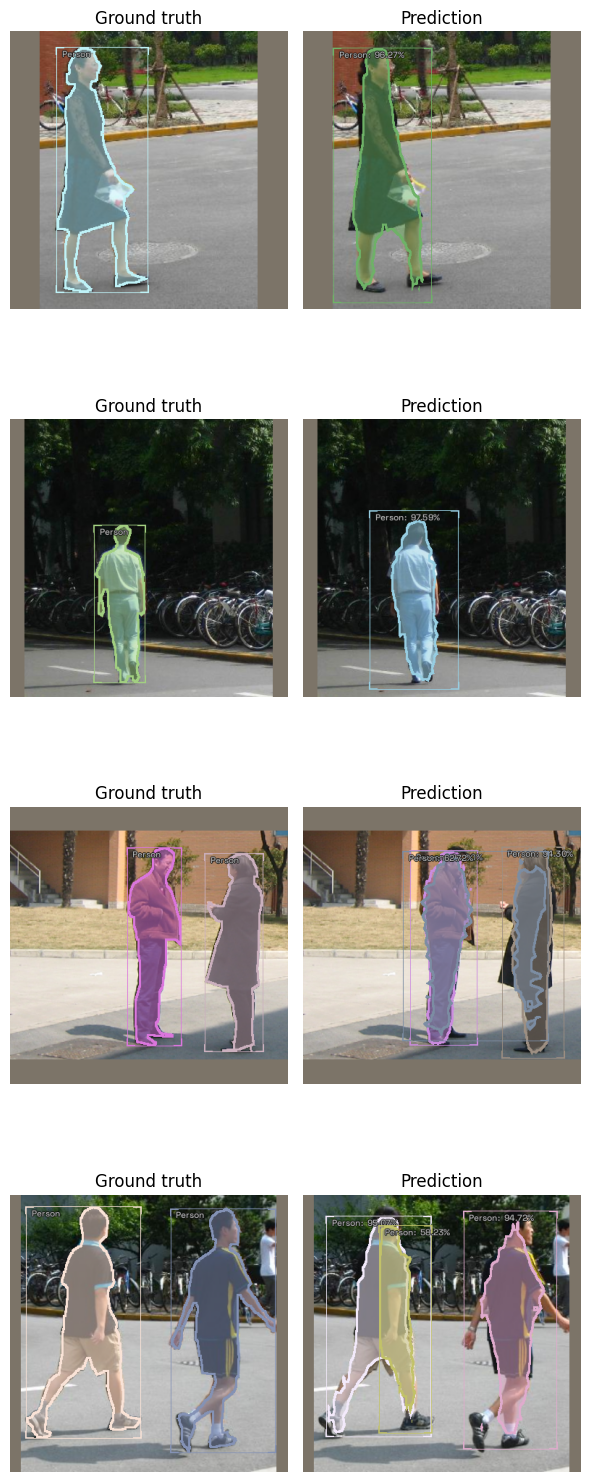

In [22]:
show_preds(preds=preds[:4], ncols=3)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).